Softmax回归是一种常用的分类方法，其公式如下：

$P(y=j|x_i) = \frac{e^{w_j^Tx_i}}{\sum_{k=1}^{K}e^{w_k^Tx_i}}$

其中，$x_i$ 为输入样本，$w_j$ 为第 $j$ 个类别的权重，$K$ 为类别总数，$P(y=j|x_i)$ 表示在给定输入 $x_i$ 的情况下，$y$ 取值为 $j$ 的概率。

交叉熵损失函数（Cross-entropy loss function）通常用来衡量分类模型的预测结果和实际标签之间的差异。对于二分类问题，其公式如下：

$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y_i\log(h_\theta(x_i)) + (1-y_i)\log(1-h_\theta(x_i))]$

其中，$m$ 为样本数，$x_i$ 为第 $i$ 个样本，$y_i$ 为第 $i$ 个样本的实际标签（0或1），$h_\theta(x_i)$ 为模型预测第 $i$ 个样本的标签为1的概率。这个损失函数的含义是：如果预测值和实际值相同，则误差为0，否则误差越大。

# 一、图像分类数据集

In [1]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
# 加载数据集

# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="./data", train=False, transform=trans, download=True)

print("Fashion-MNIST数据集下载 and 加载完成.")
print("训练集数据量:", len(mnist_train))
print("测试集数据量:", len(mnist_test))
print("每个图像的高度和宽度:", mnist_train[0][0].shape)

100.0%


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100.0%


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100.0%

Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Fashion-MNIST数据集下载 and 加载完成.
训练集数据量: 60000
测试集数据量: 10000
每个图像的高度和宽度: torch.Size([1, 28, 28])


In [3]:
"""
Fashion-MNIST中包含的10个类别，
分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。
以下函数用于在数字标签索引及其文本名称之间进行转换。
"""


def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


# test
print(get_fashion_mnist_labels([1, 2]))

['trouser', 'pullover']


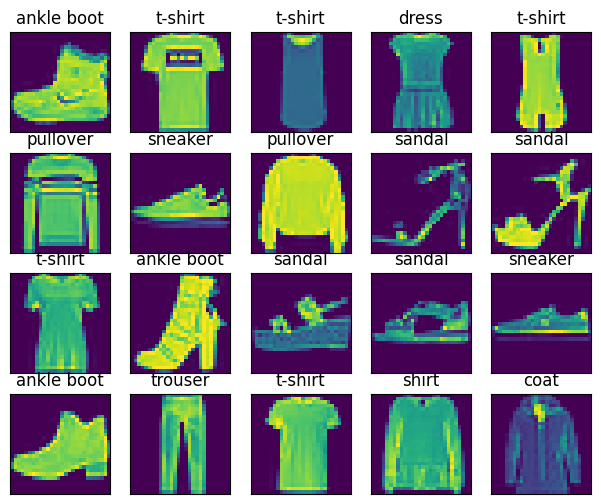

In [4]:
%matplotlib inline

# 查看样本图像数据
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)  # 创建一个包含：num_rows行 num_cols列列子图的长宽为figsize的图像
    axes = axes.flatten()  # 展平成一个一维数组
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):  # 图片张量转为numpy数组
            ax.imshow(img.numpy())
        else:  # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


num_rows = 4  # 行数
num_cols = 5  # 列数
batch_size = num_rows * num_cols
X, y = next(iter(data.DataLoader(mnist_train, batch_size=batch_size)))
show_images(X.reshape(batch_size, 28, 28), num_rows, num_cols, titles=get_fashion_mnist_labels(y));

In [5]:
# 小批量读取
batch_size = 250
num_workers = 4  # 使用4个进程来读取数据

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=num_workers)

In [6]:
"""
定义load_data_fashion_mnist函数，用于获取和读取Fashion-MNIST数据集。
这个函数返回训练集和验证集的数据迭代器。 此外，这个函数还接受一个可选参数resize，用来将图像大小调整为另一种形状。
"""


def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=num_workers),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=num_workers))

# 二、softmax回归的从零开始实现

In [7]:
batch_size = 250
train_iter, test_iter = load_data_fashion_mnist(batch_size)


In [8]:
# 初始化模型参数
num_inputs = 28 * 28
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [9]:
lr = 0.05  # 学习率


def sgd(params, lr, batch_size):
    """小批量随机梯度下降 sgd算法"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()


def updater(batch_size):  # 更新参数
    return sgd([W, b], lr, batch_size)


In [10]:
# 定义softmax操作
"""
注意，虽然这在数学上看起来是正确的，但我们在代码实现中有点草率。
矩阵中的非常大或非常小的元素可能造成数值上溢或下溢，但我们没有采取措施来防止这点。
例如：exp(50)=?,exp(5000)=?(OverflowError: math range error)
为了缓解这种数值稳定性问题，通常采用对输入进行平移或缩放操作来避免指数函数中出现过大或过小的值。
常见的方法包括使用log-sum-exp技巧或将输入值减去最大值等。
"""


def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制


# 定义模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [11]:
# 定义损失函数，交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
"""
函数cross_entropy的实现可能存在问题，具体取决于其如何处理输入数据。
交叉熵损失函数的定义包括取对数操作，因此需要注意对数函数的定义域。
如果输入数据中包含非正值（即小于等于零的值），那么对这些值取对数将导致错误或异常。
因此，在实现交叉熵损失函数时需要特别注意对输入数据进行预处理，以确保其不包含非正值。
"""

# 计算预测正确的数量
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)  # 在指定维度上返回张量中最大值所在的索引
    cmp = y_hat.type(y.dtype) == y  # 类型转换为同一类别int，再进行比较是否相等
    return float(cmp.type(y.dtype).sum())


# test
y = torch.tensor([0, 2])  # 假设真是标签是0,2
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])  # 假设预测结果
print("真实标签的预测概率：", y_hat[[0, 1], y])
print("cross_entropy=", cross_entropy(y_hat, y))
print("计算预测正确的数量：", accuracy(y_hat, y))

真实标签的预测概率： tensor([0.1000, 0.5000])
cross_entropy= tensor([2.3026, 0.6931])
计算预测正确的数量： 1.0


In [12]:
# 这里定义一个实用程序类Accumulator，用于对多个变量进行累加
class Accumulator:
    """在n个变量上累加"""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 如果是torch.nn.Module, 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())  # numel()获取张量中元素的总数
    return metric[0] / metric[1]  # evaluate_accuracy = 正确预测数 / 预测总数

In [13]:
# 训练
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()  # 如果是torch.nn.Module, 将模型设置为训练模式
    metric = Accumulator(3)  # 训练损失总和、训练准确数量总和、样本数
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用自定义的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练正确率【训练损失总和/样本数】，【训练准确数量总和/样本数】
    return metric[0] / metric[2], metric[1] / metric[2]

In [14]:
# 定义一个在动画中绘制数据的实用程序类Animator
from matplotlib_inline import backend_inline
from IPython import display


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


class Animator:
    """在动画中绘制数据"""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        backend_inline.set_matplotlib_formats('svg')  # 使用svg格式在Jupyter中显示绘图
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

最终结果：
train_loss=0.4768,train_acc=0.8407,test_acc=0.8255


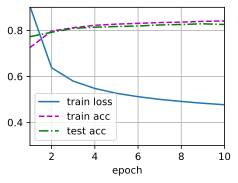

In [15]:
# 训练
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        # train_loss, train_acc = train_metrics
    train_loss, train_acc = train_metrics
    print("最终结果：\n"
          "train_loss={:.4f},train_acc={:.4f},test_acc={:.4f}".format(train_loss, train_acc, test_acc))
    assert train_loss < 0.5, train_loss  # 最终训练结果，train_loss 应该小于0.5
    assert train_acc <= 1 and train_acc > 0.5, train_acc  # 最终训练结果，train_acc 应该大于0.5
    assert test_acc <= 1 and test_acc > 0.5, test_acc  # 最终训练结果，test_acc 应该大于0.5


num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

预测准确度：8255.0/10000.0=0.8255


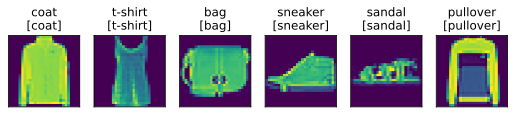

In [16]:
# 预测
def predict_ch3(net, test_iter, n=6):
    """预测标签（定义见第3章）"""
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in test_iter:
        y_hat = net(X)
        metric.add(accuracy(y_hat, y), y.numel())  # numel()获取张量中元素的总数

    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = ["{}\n[{}]".format(true, pred) for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    print("预测准确度：{}/{}={}".format(metric[0], metric[1], metric[0] / metric[1]))


predict_ch3(net, test_iter)

# 三、softmax回归的简洁实现

In [17]:
# 定义模型
from torch import nn

# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

In [18]:
# 初始化模型参数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [19]:
# 定义损失函数
loss = nn.CrossEntropyLoss(reduction='none')

In [20]:
# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.1)


KeyboardInterrupt



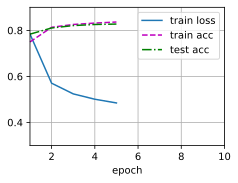

In [21]:
# 训练
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [ ]:
# 预测
def predict_ch3(net, test_iter, n=6):
    """预测标签（定义见第3章）"""
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in test_iter:
        y_hat = net(X)
        metric.add(accuracy(y_hat, y), y.numel())  # numel()获取张量中元素的总数

    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = ["{}\n[{}]".format(true, pred) for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])
    print("预测准确度：{}/{}={}".format(metric[0], metric[1], metric[0] / metric[1]))


predict_ch3(net, test_iter)